In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# About the Data:

Some of the original structure are deleted or censored. For those are left:
Basic data like:

* ID
* class: categorical, initially students were divided into 2 classes, yet teachers suspect that of different classes students may performance significant differently.
* gender
* race: categorical and censored
* GPA: real numbers, float

Some teachers assume that scores of math curriculums can represent one's likelihood perfectly:

* Algebra: real numbers, Advanced Algebra
……

Some assume that background of students can affect their choices and likelihood significantly, which are all censored as:

* from1: students' home locations
* from2: a probably bad indicator for preference on mathematics
* from 3: how did students apply for this university (undergraduate)
* from4: a probably bad indicator for family background. 0 with more wealth, 4 with more poverty

The final indicator y:

* 0, one fails to apply for the graduate school, who may apply again or search jobs in the future
* 1, success, inland
* 2, success, abroad

# Utilities

In [313]:
# Importing all the tools

# Regular EDA (Exploratory Data Analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier, BaggingClassifier, StackingClassifier
from sklearn.svm import LinearSVC, SVC  
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Data Preprocessing

In [2]:
data = pd.read_csv('../input/students-data-analysis/Students data.csv')
data

,ID,class,gender,race,GPA,Algebra,Calculus1,Calculus2,Statistics,Probability,Measure,Functional_analysis,from1,from2,from3,from4,y
0,1141,A,male,1,73.47,64,81,87,60,74,71,60,A,A,A,3,0
1,1142,A,female,1,71.22,57,50,51,51,55,62,61,B,A,A,2,0
2,1143,A,female,2,74.56,47,48,71,60,61,68,64,C,A,A,0,1
3,1144,A,female,1,72.89,46,72,38,60,29,54,51,D,A,A,0,0
4,1145,A,female,1,70.11,49,45,63,60,66,66,61,E,A,A,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,1241,A,female,1,88.34,87,83,92,98,93,86,90,M,B,A,0,1
101,1242,B,male,1,89.84,98,77,95,98,96,88,100,A,B,A,0,1
102,1243,B,male,1,88.82,83,80,91,98,93,95,71,T,B,A,0,2
103,1244,A,male,1,86.60,92,82,91,99,94,82,78,S,B,A,0,2


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   105 non-null    int64  
 1   class                105 non-null    object 
 2   gender               105 non-null    object 
 3   race                 105 non-null    int64  
 4   GPA                  105 non-null    float64
 5   Algebra              105 non-null    int64  
 6   Calculus1            105 non-null    int64  
 7   Calculus2            105 non-null    int64  
 8   Statistics           105 non-null    int64  
 9   Probability          105 non-null    int64  
 10  Measure              105 non-null    int64  
 11  Functional_analysis  105 non-null    int64  
 12  from1                105 non-null    object 
 13  from2                105 non-null    object 
 14  from3                105 non-null    object 
 15  from4                105 non-null    int

In [4]:
# Checking Missing values 
data.isnull().sum()

ID                     0
class                  0
gender                 0
race                   0
GPA                    0
Algebra                0
Calculus1              0
Calculus2              0
Statistics             0
Probability            0
Measure                0
Functional_analysis    0
from1                  0
from2                  0
from3                  0
from4                  0
y                      0
dtype: int64

In [5]:
features = data.columns
features

Index(['ID', 'class', 'gender', 'race', 'GPA', 'Algebra', 'Calculus1',
       'Calculus2', 'Statistics', 'Probability', 'Measure',
       'Functional_analysis', 'from1', 'from2', 'from3', 'from4', 'y'],
      dtype='object')

In [6]:
# Encode the categorical columns 
data['class'] = pd.Categorical(data['class']).codes
data['gender'] = pd.Categorical(data['gender']).codes
data['from1'] = pd.Categorical(data['from1']).codes
data['from2'] = pd.Categorical(data['from2']).codes
data['from3'] = pd.Categorical(data['from3']).codes
data['from4'] = pd.Categorical(data['from4']).codes
data

,ID,class,gender,race,GPA,Algebra,Calculus1,Calculus2,Statistics,Probability,Measure,Functional_analysis,from1,from2,from3,from4,y
0,1141,0,1,1,73.47,64,81,87,60,74,71,60,0,0,0,2,0
1,1142,0,0,1,71.22,57,50,51,51,55,62,61,3,0,0,1,0
2,1143,0,0,2,74.56,47,48,71,60,61,68,64,4,0,0,0,1
3,1144,0,0,1,72.89,46,72,38,60,29,54,51,5,0,0,0,0
4,1145,0,0,1,70.11,49,45,63,60,66,66,61,6,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,1241,0,0,1,88.34,87,83,92,98,93,86,90,14,1,0,0,1
101,1242,1,1,1,89.84,98,77,95,98,96,88,100,0,1,0,0,1
102,1243,1,1,1,88.82,83,80,91,98,93,95,71,21,1,0,0,2
103,1244,0,1,1,86.60,92,82,91,99,94,82,78,20,1,0,0,2


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   105 non-null    int64  
 1   class                105 non-null    int8   
 2   gender               105 non-null    int8   
 3   race                 105 non-null    int64  
 4   GPA                  105 non-null    float64
 5   Algebra              105 non-null    int64  
 6   Calculus1            105 non-null    int64  
 7   Calculus2            105 non-null    int64  
 8   Statistics           105 non-null    int64  
 9   Probability          105 non-null    int64  
 10  Measure              105 non-null    int64  
 11  Functional_analysis  105 non-null    int64  
 12  from1                105 non-null    int8   
 13  from2                105 non-null    int8   
 14  from3                105 non-null    int8   
 15  from4                105 non-null    int

In [8]:
data.describe()

,ID,class,gender,race,GPA,Algebra,Calculus1,Calculus2,Statistics,Probability,Measure,Functional_analysis,from1,from2,from3,from4,y
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,1193.000000,0.276190,0.352381,1.790476,82.957048,76.057143,71.961905,78.942857,85.133333,83.876190,80.761905,75.323810,12.904762,0.695238,0.628571,0.257143,0.714286
std,30.454885,0.449257,0.480003,1.673867,6.053187,11.722618,12.197039,14.997326,10.269509,10.514363,10.296119,13.003324,7.781294,0.462514,1.257723,0.460530,0.828742
min,1141.000000,0.000000,0.000000,1.000000,63.490000,46.000000,38.000000,17.000000,51.000000,29.000000,54.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1167.000000,0.000000,0.000000,1.000000,79.340000,67.000000,64.000000,71.000000,80.000000,79.000000,74.000000,67.000000,6.000000,0.000000,0.000000,0.000000,0.000000
50%,1193.000000,0.000000,0.000000,1.000000,84.110000,76.000000,73.000000,83.000000,87.000000,85.000000,81.000000,76.000000,12.000000,1.000000,0.000000,0.000000,0.000000
75%,1219.000000,1.000000,1.000000,1.000000,87.300000,84.000000,80.000000,91.000000,92.000000,92.000000,89.000000,85.000000,19.000000,1.000000,0.000000,0.000000,1.000000
max,1245.000000,1.000000,1.000000,7.000000,93.710000,98.000000,100.000000,99.000000,100.000000,97.000000,100.000000,100.000000,27.000000,1.000000,4.000000,2.000000,2.000000


In [9]:
data.head().T

,0,1,2,3,4
ID,1141.00,1142.00,1143.00,1144.00,1145.00
class,0.00,0.00,0.00,0.00,0.00
gender,1.00,0.00,0.00,0.00,0.00
race,1.00,1.00,2.00,1.00,1.00
GPA,73.47,71.22,74.56,72.89,70.11
Algebra,64.00,57.00,47.00,46.00,49.00
Calculus1,81.00,50.00,48.00,72.00,45.00
Calculus2,87.00,51.00,71.00,38.00,63.00
Statistics,60.00,51.00,60.00,60.00,60.00
Probability,74.00,55.00,61.00,29.00,66.00


# EDA (Exploratory Data Aanalysis)

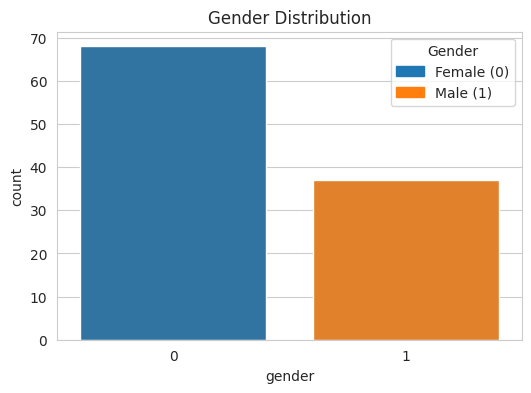

In [227]:
# 1. Countplot of gender distribution
plt.figure(figsize=(6, 4))
ax = sns.countplot(x="gender", data=data)

plt.title("Gender Distribution")

# Custom legend handles
male_patch = mpatches.Patch(color=sns.color_palette()[1], label='Male (1)')
female_patch = mpatches.Patch(color=sns.color_palette()[0], label='Female (0)')

# Add the custom legend to the plot
plt.legend(handles=[female_patch, male_patch], title='Gender')

# Display the plot
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


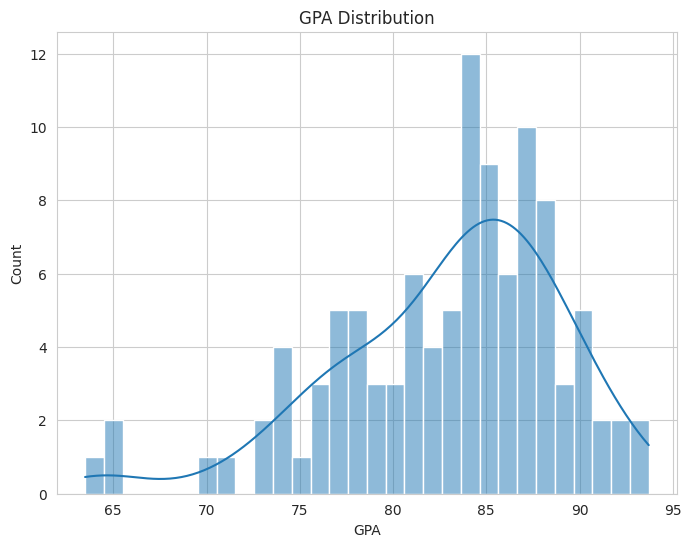

In [219]:
# 2. Histogram of GPA 
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x="GPA", bins=30, kde=True)
plt.title("GPA Distribution")
plt.show()

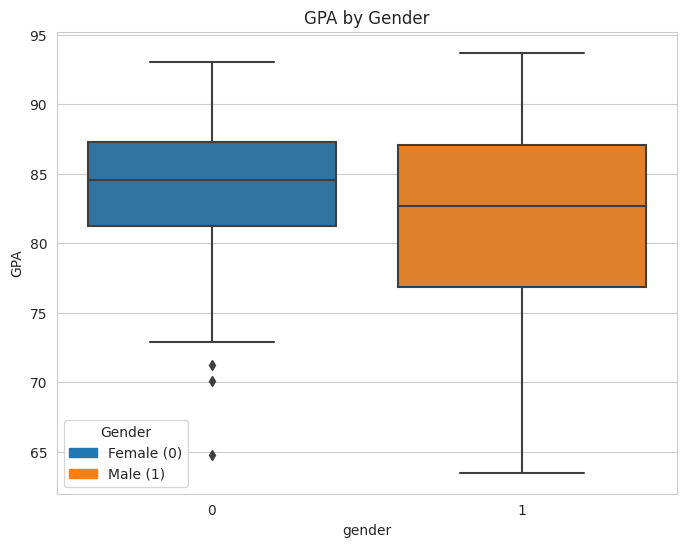

In [228]:
# 3. Boxplot of GPA by gender
plt.figure(figsize=(8, 6))
sns.boxplot(x="gender", y="GPA", data=data)
plt.title("GPA by Gender")
male_patch = mpatches.Patch(color=sns.color_palette()[1], label='Male (1)')
female_patch = mpatches.Patch(color=sns.color_palette()[0], label='Female (0)')
plt.legend(handles=[female_patch, male_patch], title='Gender')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

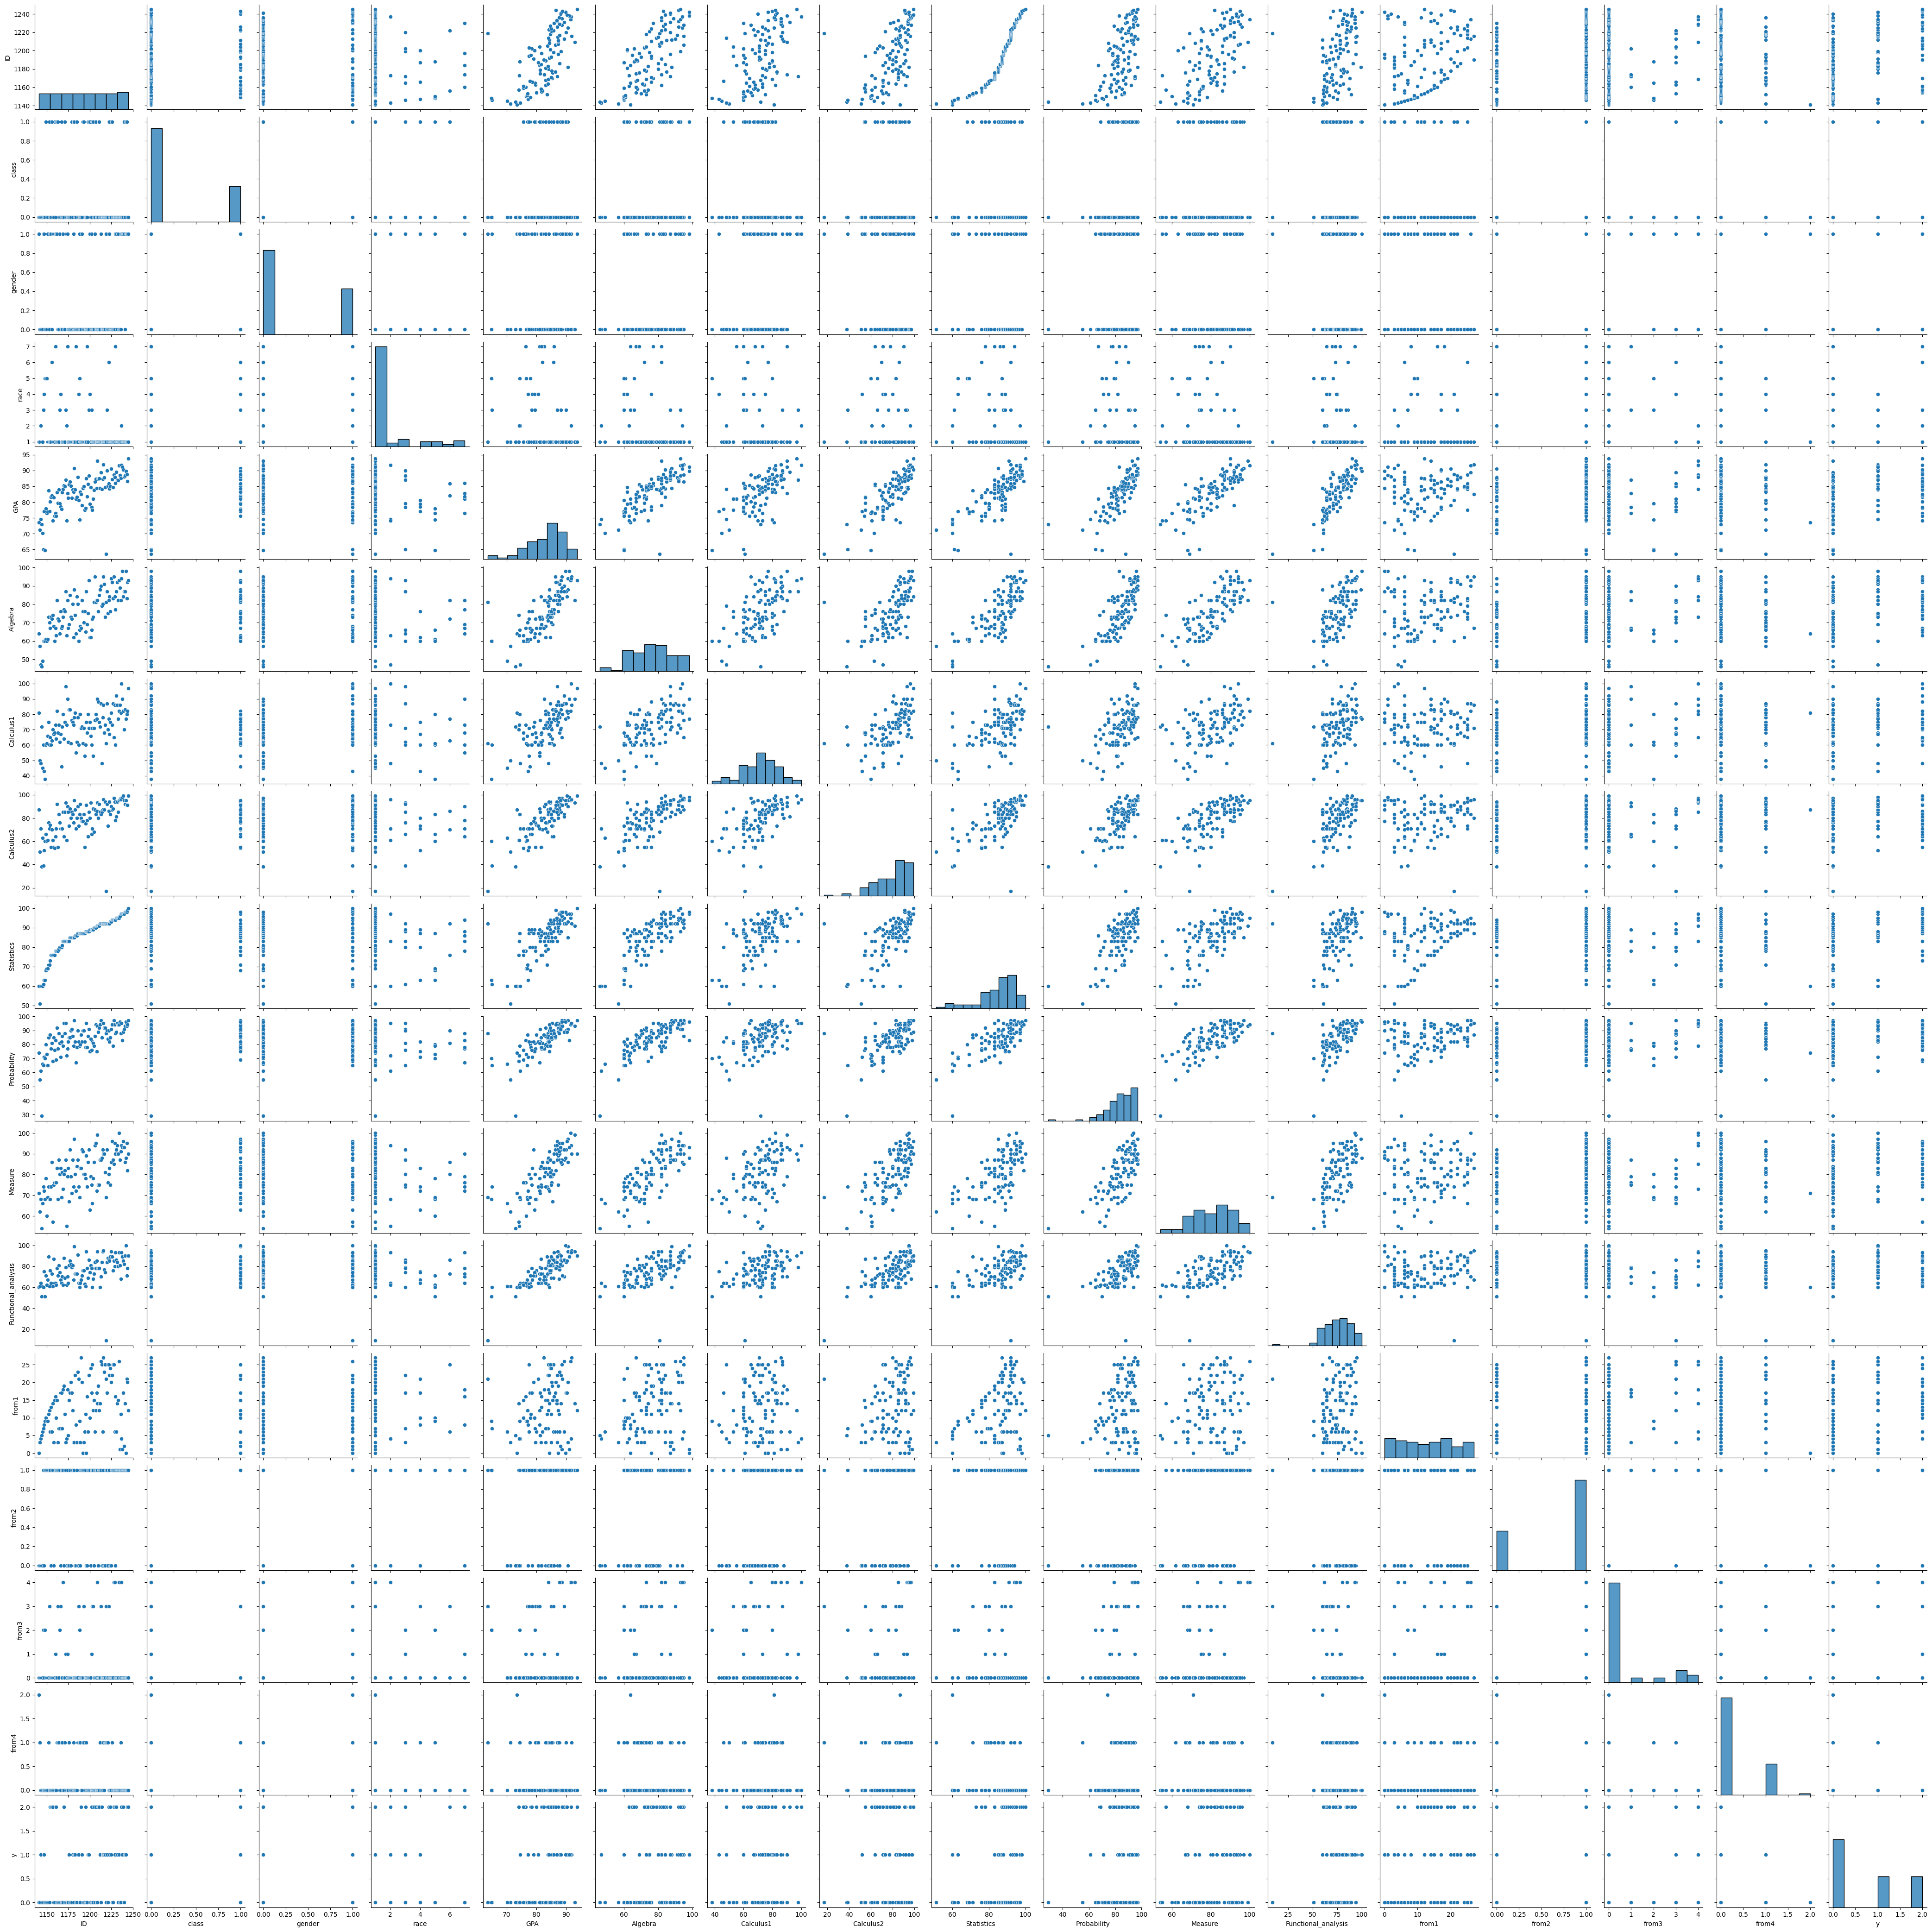

In [13]:
sns.pairplot(data=data)

<Axes: >

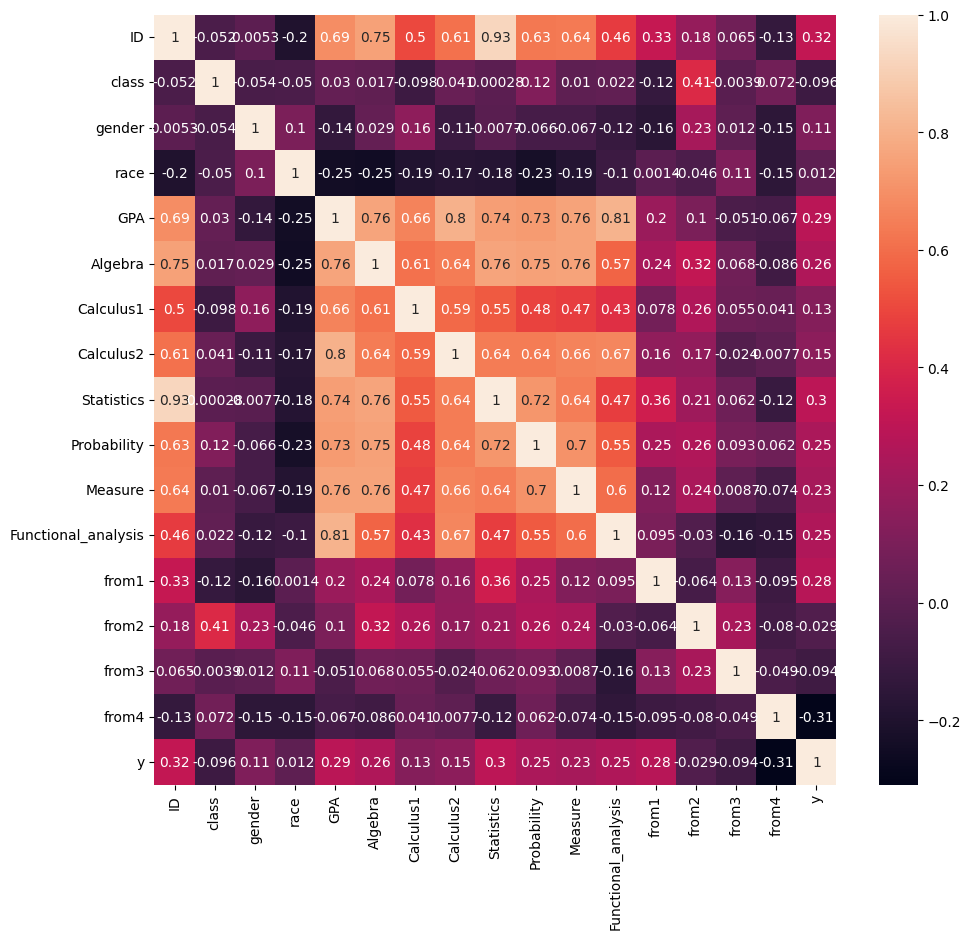

In [15]:
plt.figure(figsize=(11,10))
sns.heatmap(data.corr(),annot=True)

## Feature Selection

The dataset has only 104 samples and the total number of features are 17. We can't train our model in this less amoount of data. So we need to drop some of the columns which are not contributing to our end goal: **to tell what makes a brilliant student who can apply for a graduate school, whether abroad or not.**

* We don't need the `ID` so we'll drop it
* From the above Correlation Matrix as `GPA` is co-related to `Algebra`, `Calculus1`, `Calculus2`, `Statistics`, `Probability`,`Measure` and `Functional Analysis` so we can only keep the `GPA` column.
* We can combine `from1`, `from2`, `from3` and `from4` to make `Background` column. As `from2` and `from4` are bad indicators so we'll take positive averages of `from1` & `from3` and negative averages of `from2` & `from4`

In [101]:
compressed_data = data.drop(["ID", "Algebra", "Calculus1", "Calculus2", "Statistics", "Probability", "Measure", "Functional_analysis"], axis=1)

In [103]:
compressed_data["Background"] = ((data["from1"] + data["from3"] - data["from2"] - data["from4"])/4)
compressed_data = compressed_data.drop(["from1", "from2", "from3", "from4"], axis=1)
compressed_data

,class,gender,race,GPA,y,Background
0,0,1,1,73.47,0,-0.50
1,0,0,1,71.22,0,0.50
2,0,0,2,74.56,1,1.00
3,0,0,1,72.89,0,1.25
4,0,0,1,70.11,0,1.50
...,...,...,...,...,...,...
100,0,0,1,88.34,1,3.25
101,1,1,1,89.84,1,-0.25
102,1,1,1,88.82,2,5.00
103,0,1,1,86.60,2,4.75


<Figure size 1800x600 with 0 Axes>

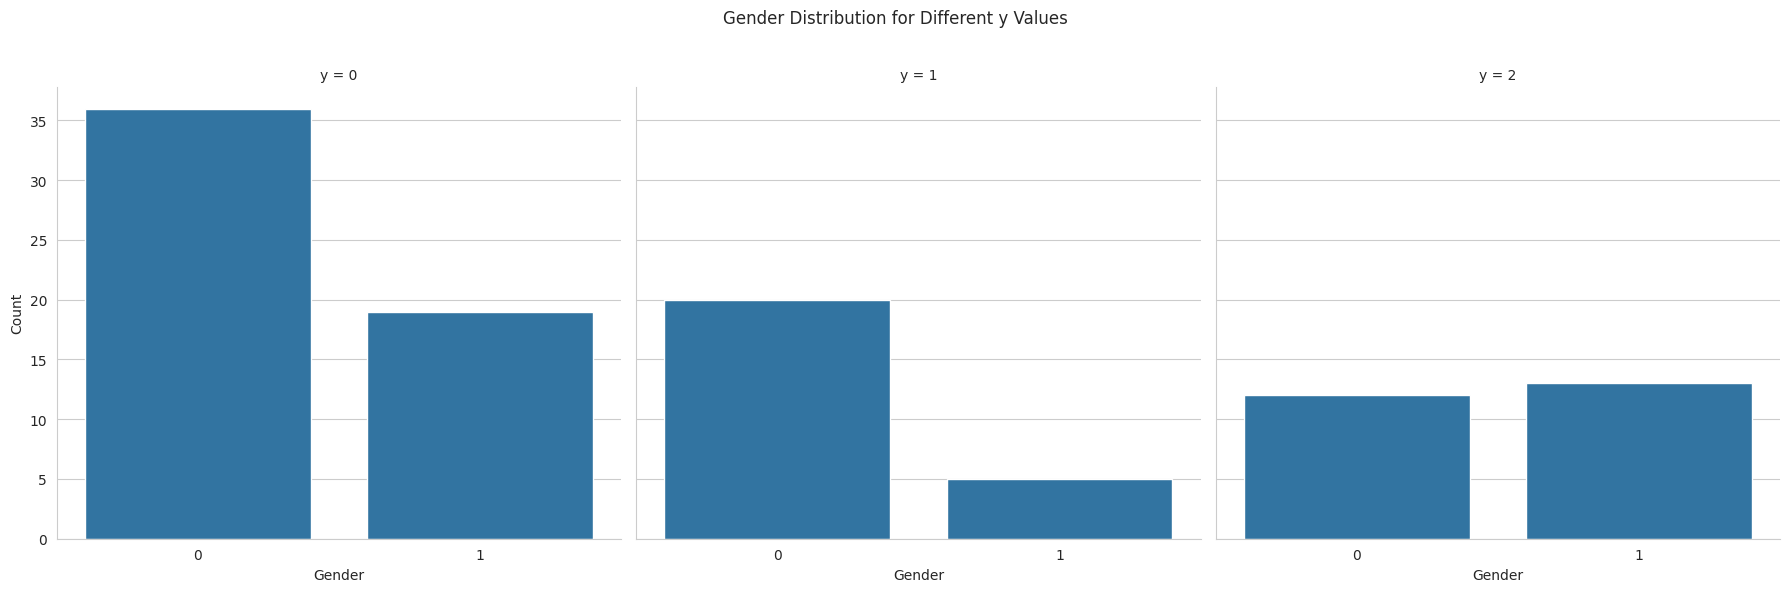

In [239]:
# Set up the matplotlib figure
plt.figure(figsize=(18, 6))

# Create a FacetGrid for the three different `y` values
g = sns.FacetGrid(compressed_data, col="y", col_wrap=3, height=6, aspect=1)

# Map the bar plot onto the grid
g.map(sns.countplot, "gender", order=[0, 1])

# Set titles and labels
g.set_titles(col_template="y = {col_name}")
g.set_axis_labels("Gender", "Count")

# Add a main title
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Gender Distribution for Different y Values')

# Display the plot
plt.show();

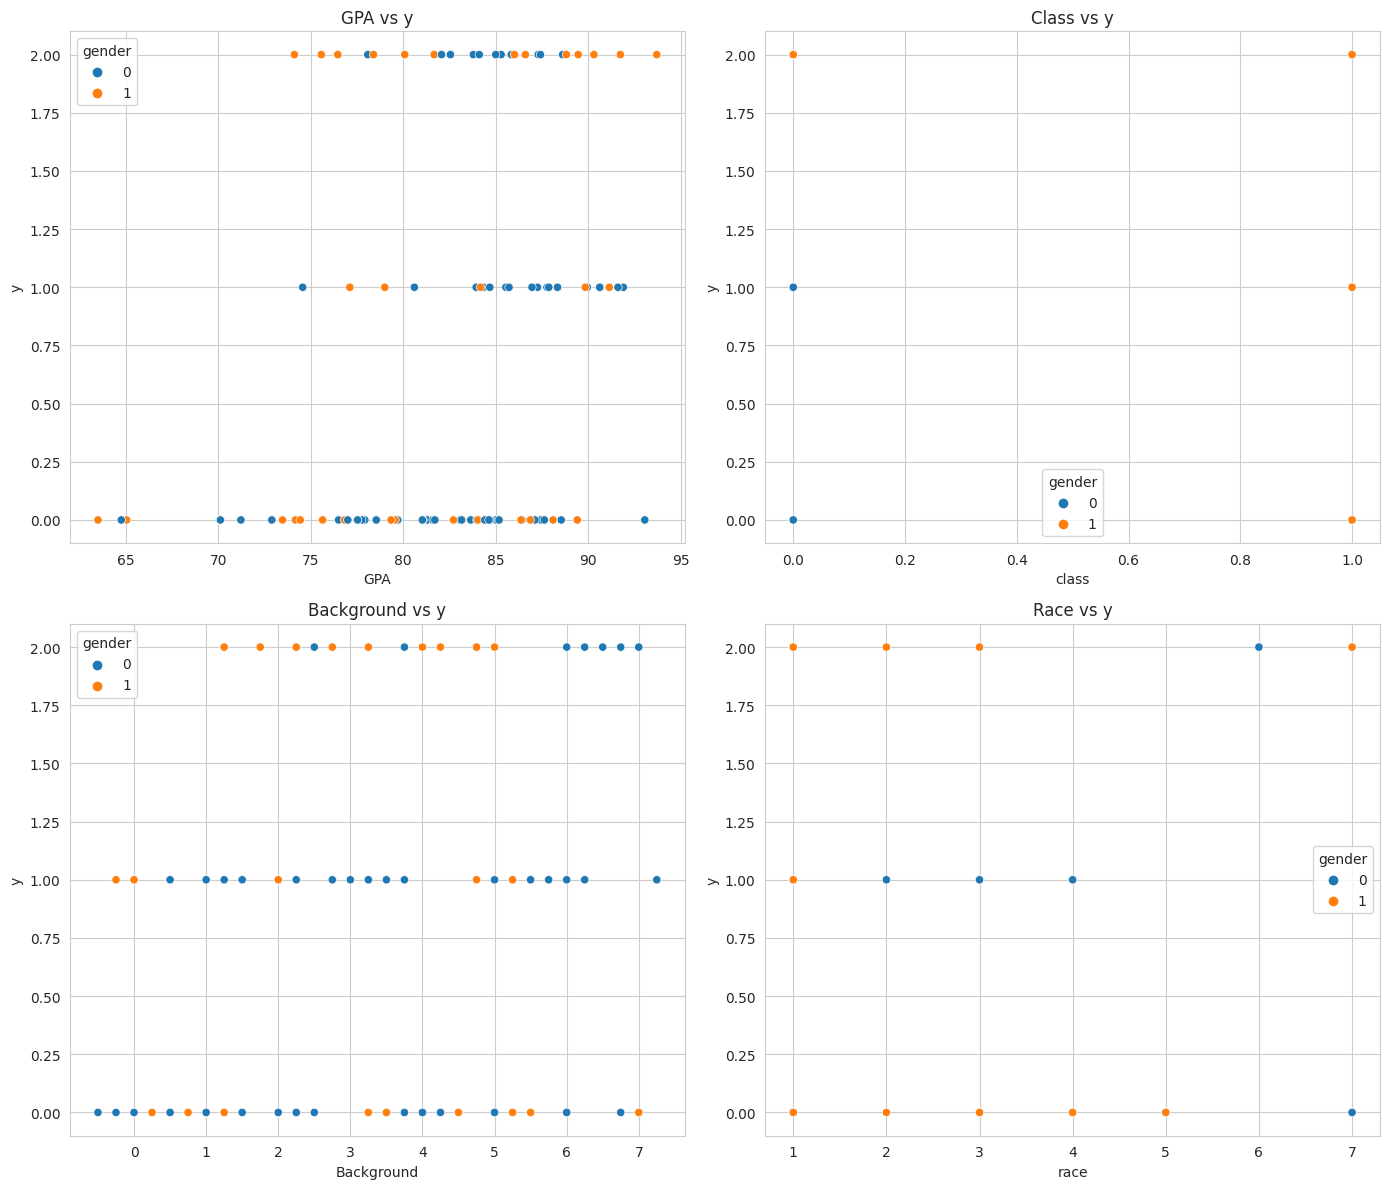

In [244]:
# Set up the matplotlib figure
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: GPA vs Student's Performance
sns.scatterplot(x='GPA', y='y', hue='gender', data=compressed_data, ax=axes[0, 0])
axes[0, 0].set_title('GPA vs y')

# Plot 2: GPA vs Class
sns.scatterplot(x='class', y='y', hue='gender', data=compressed_data, ax=axes[0, 1])
axes[0, 1].set_title('Class vs y')

# Plot 3: Background vs Class
sns.scatterplot(x='Background', y='y', hue='gender', data=compressed_data, ax=axes[1, 0])
axes[1, 0].set_title('Background vs y')

# Plot 4: Background vs Race
sns.scatterplot(x='race', y='y', hue='gender', data=compressed_data, ax=axes[1, 1])
axes[1, 1].set_title('Race vs y')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

# Modelling

In [104]:
# Split data into X and y

X = compressed_data.drop("y", axis=1)
y = compressed_data["y"]

In [105]:
X

,class,gender,race,GPA,Background
0,0,1,1,73.47,-0.50
1,0,0,1,71.22,0.50
2,0,0,2,74.56,1.00
3,0,0,1,72.89,1.25
4,0,0,1,70.11,1.50
...,...,...,...,...,...
100,0,0,1,88.34,3.25
101,1,1,1,89.84,-0.25
102,1,1,1,88.82,5.00
103,0,1,1,86.60,4.75


In [106]:
y

0      0
1      0
2      1
3      0
4      0
      ..
100    1
101    1
102    2
103    2
104    2
Name: y, Length: 105, dtype: int64

In [345]:
# Splitting the data into training and validation sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

In [319]:
def rmse(y_test, y_pred):
    """
    Caculates root mean squared error between predictions and
    true labels.
    """
    return np.sqrt(mean_squared_error(y_test, y_pred))

# Comparing the Results

In [217]:
model_r2_score = {
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso', 'ElasticNet', 'ElasticNetCV', 'Ensemble Method'],
    'R2_Score': [lin_r2_score, ridge_r2_score, las_r2_score, en_r2_score, encv_r2_score, voting_r2_score]
}

comparison = pd.DataFrame(model_r2_score)
comparison

,Model,R2_Score
0,Linear Regression,0.140142
1,Ridge Regression,0.147119
2,Lasso,0.136985
3,ElasticNet,0.157951
4,ElasticNetCV,0.110981
5,Ensemble Method,0.166407


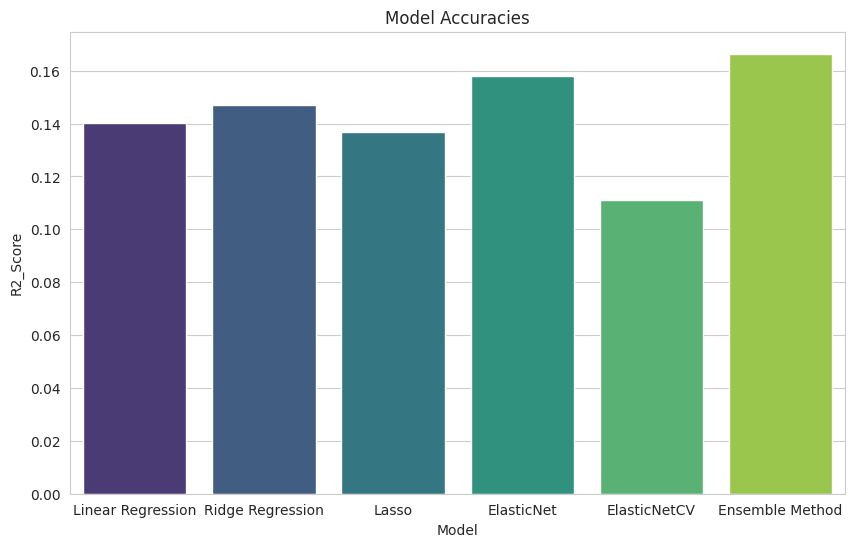

In [218]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R2_Score', data=comparison, palette='viridis')

# Add title and labels
plt.title('Model Accuracies')
plt.xlabel('Model')
plt.ylabel('R2_Score')

# Display the plot
plt.show()

## 1. Logistic Regression

In [346]:
lr_clf = LogisticRegression(max_iter=10)
lr_clf.fit(X_train, y_train)

# Making prediction on the validation set
y_pred = lr_clf.predict(X_test)

# Calculating accuracy
acc_lr = accuracy_score(y_test, y_pred)
f1_lr = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", acc_lr, "F1-Score:", f1_lr)

Accuracy: 1.0 F1-Score: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


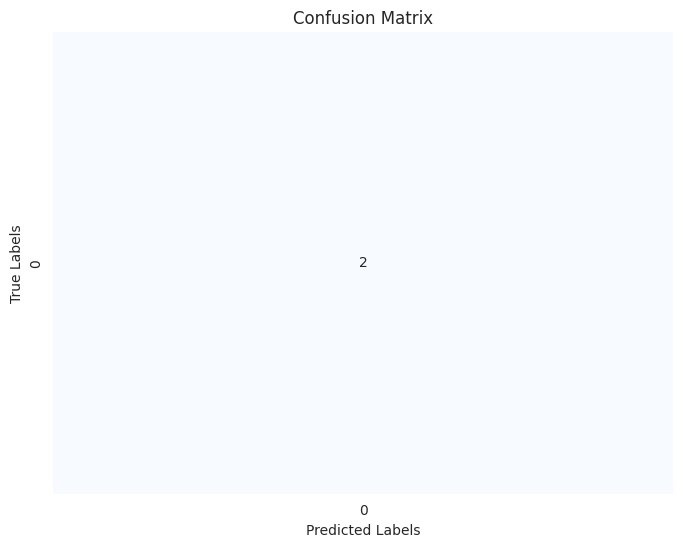

In [347]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## 2. Random Forest Classifier

In [348]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=1, min_samples_leaf=3)
rf_clf.fit(X_train, y_train)

# Making prediction on the validation set
y_pred = clf.predict(X_test)

# Calculating accuracy
acc_rf = accuracy_score(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", acc_rf, "F1-Score:", f1_rf)

Accuracy: 0.5 F1-Score: 0.6666666666666666


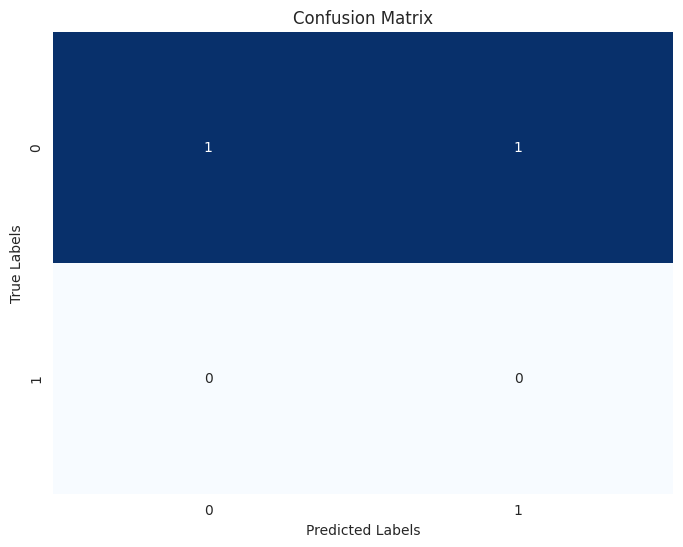

In [349]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## 3. SVC

In [350]:
svc_clf = SVC()
svc_clf.fit(X_train, y_train)

# Making prediction on the validation set
y_pred = svc_clf.predict(X_test)

# Calculating accuracy
acc_svc = accuracy_score(y_test, y_pred)
f1_svc = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", acc_svc, "F1-Score:", f1_svc)

Accuracy: 1.0 F1-Score: 1.0


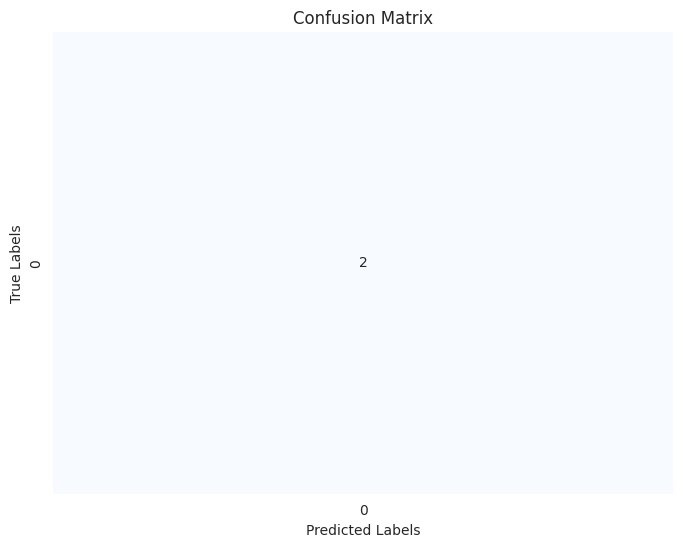

In [351]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## 4. Naive Bayes

In [352]:
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

# Making prediction on the validation set
y_pred = svc_clf.predict(X_test)

# Calculating accuracy
acc_nb = accuracy_score(y_test, y_pred)
f1_nb = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", acc_nb, "F1-Score:", f1_nb)

Accuracy: 1.0 F1-Score: 1.0


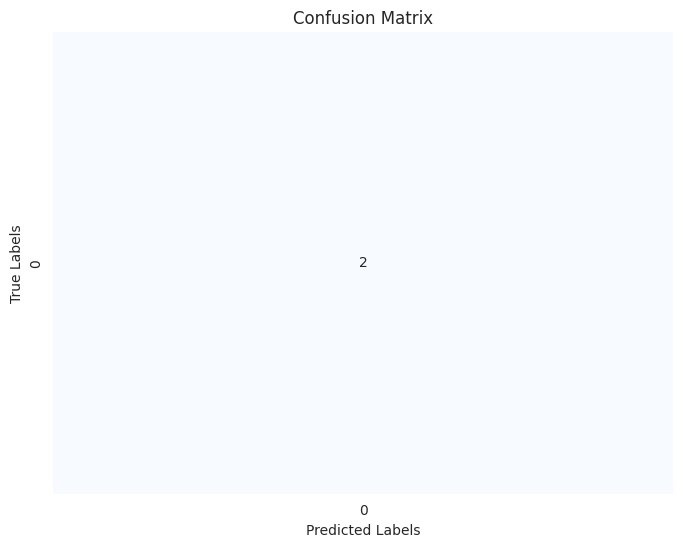

In [353]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## 5.

In [355]:
# Define the classifiers
lr_clf = LogisticRegression(max_iter=10)
svc_clf = SVC(probability=True)  # Set probability=True
nb_clf = GaussianNB()

# Create a voting classifier
voting_classifier = VotingClassifier(estimators=[
    ('lr_clf', lr_clf),
    ('svc_clf', svc_clf),
    ('nb_clf', nb_clf)
], voting='soft')  # 'soft' voting uses predicted probabilities for the final decision

# Train the ensemble model
voting_classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = voting_classifier.predict(X_test)

# Evaluate the ensemble model
acc_en = accuracy_score(y_test, y_pred)
f1_en = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", acc_en, "F1-Score:", f1_en)


Accuracy: 1.0 F1-Score: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# I need to do Data Sampling 😭 I need more data to train🥹 I can try PCA also